# Advanced Portfolio Optimization and Risk Analysis

This notebook presents a workflow for constructing and analyzing an optimal investment portfolio. It demonstrates:
1. **Configuration & Data Pipeline**: Setting up parameters and processing market data using modern estimation techniques.
2.  **Interactive Optimization**: Finding optimal portfolio weights to maximize risk-adjusted returns.
3.  **Risk & Return Simulation**: Projecting future performance and assessing risk using Monte Carlo methods.

The core logic is encapsulated in the accompanying `.py` modules, keeping this notebook focused on the high-level analysis workflow and results.

## 1. Setup and Configuration

### 1.1. Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from ipywidgets import FloatSlider, IntSlider, interact

from portfolio_analyzer.analysis.backtester import Backtester
from portfolio_analyzer.config import AppConfig
from portfolio_analyzer.data import input_preparator as ip
from portfolio_analyzer.interactive.session import PortfolioAnalysisSession
from portfolio_analyzer.logging_config import setup_logging
from portfolio_analyzer.reporting.display import (
    display_backtest_summary_html,
    display_optimization_summary_html,
)
from portfolio_analyzer.reporting.plotting import (
    calculate_correlation_matrix,
    plot_correlation_heatmap,
    plot_correlation_network,
    plot_efficient_frontier,
)

setup_logging()

sns.set_theme(style="whitegrid", palette="pastel")
sns.set_context("notebook")

2025-06-21 15:48:27 - root - INFO - Logging configured. Console level: INFO, File level: DEBUG


### 1.2. Define Parameters
All key parameters are managed in the `AppConfig` class in `config.py`. This provides a centralized way to control tickers, date ranges, and model hyperparameters. User-specific views for the Black-Litterman model can also be defined here.

In [1]:
# --- General Model Configuration ---
config = AppConfig()

## 2. Data Pipeline & Input Preparation
The `input_preparator` module encapsulates the entire data preparation pipeline. It fetches historical prices and market capitalizations, calculates log returns, and prepares the final mean return vector and covariance matrix for optimization.

**New Feature**: If enabled, the pipeline now automatically runs a DCF calculation for each asset. These are used to generate views for the Black-Litterman model, providing forward-looking estimates of return. The model also incorporates a special rule: assets without a market capitalization will use their implied equilibrium return rather than the full Black-Litterman posterior return, blending market-neutral priors with forward-looking views.

The pipeline uses techniques like EWMA, Ledoit-Wolf shrinkage, and Black-Litterman blending to create robust and stable inputs.


In [2]:
try:
    # The prepare_model_inputs function now internally handles the creation
    # of DCF-based views if enabled in the config.
    model_inputs = ip.prepare_model_inputs(config)
    mean_returns = model_inputs.mean_returns
    cov_matrix = model_inputs.cov_matrix
    log_returns = model_inputs.log_returns
    close_df = model_inputs.close_df
    final_tickers = model_inputs.final_tickers
except Exception as e:
    print(f"Data pipeline failed: {e}. Cannot proceed with analysis.")
    mean_returns, cov_matrix, log_returns, close_df, final_tickers = (
        pd.Series(dtype=float),
        pd.DataFrame(),
        pd.DataFrame(),
        pd.DataFrame(),
        [],
    )

2025-06-21 15:48:27 - portfolio_analyzer.data.input_preparator - INFO - --- Starting Data Pipeline for 18 tickers from 2020-06-22 to 2025-06-21 ---
2025-06-21 15:48:27 - portfolio_analyzer.data.input_preparator - INFO - DCF Views Enabled: True
2025-06-21 15:48:27 - portfolio_analyzer.data.data_fetcher - INFO - Fetching market cap data for 18 tickers...
2025-06-21 15:48:34 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000MVB.IR. Defaulting to 0.
2025-06-21 15:48:34 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P0001IMY8.F. Defaulting to 0.
2025-06-21 15:48:34 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000B0I. Defaulting to 0.
2025-06-21 15:48:34 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 18 tickers...
2025-06-21 15:48:37 - portfolio_analyzer.data.input_preparator - INFO - Proceeding with 18 tickers that have valid price data.
2025-06-2

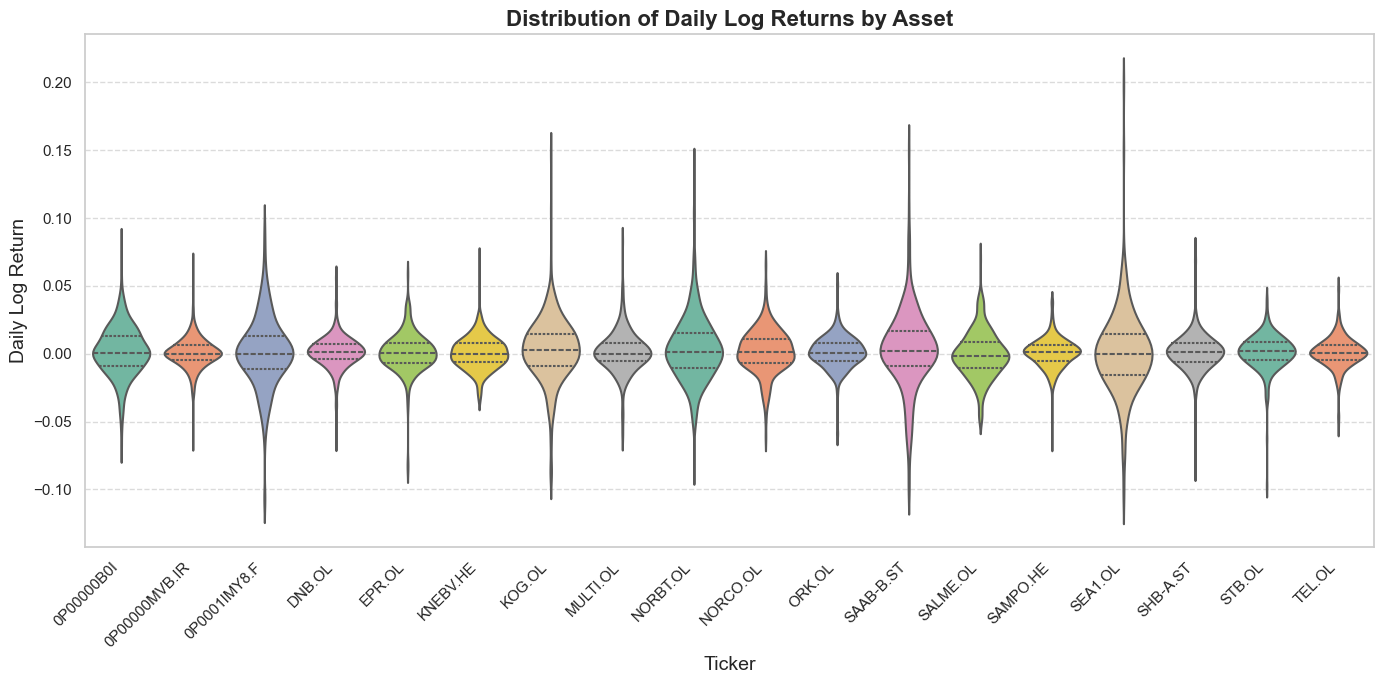

In [3]:
# Visualize the distribution of daily returns for the processed assets
plt.figure(figsize=(14, 7))
sns.violinplot(data=log_returns, palette="Set2", inner="quartile", linewidth=1.5)
plt.title("Distribution of Daily Log Returns by Asset", fontsize=16, fontweight="bold")
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Daily Log Return", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.tight_layout()
plt.show()

### 2.1. Review Model Return Estimates
After running the pipeline, we can compare the different return estimates for our assets:
- **Historical (EWMA Shrunk)**: The backward-looking return, based on historical price movements.
- **Implied Equilibrium**: The forward-looking return implied by the market capitalization weights (i.e., what the market collectively assumes).
- **BL Posterior (Final)**: The final blended return from the Black-Litterman model, which combines the implied equilibrium returns with our DCF-based views. This is the vector that will be used for optimization.

In [4]:
if "model_inputs" in locals() and model_inputs and not model_inputs.mean_returns.empty:
    returns_df = pd.DataFrame(index=final_tickers)
    returns_df["Historical"] = model_inputs.hist_mean_returns

    if model_inputs.implied_equilibrium_returns is not None:
        returns_df["Implied Equilibrium"] = model_inputs.implied_equilibrium_returns

    returns_df["BL Posterior (Final)"] = model_inputs.mean_returns

    # Display the DataFrame, formatted as percentages
    display(
        returns_df.style.format("{:.2%}")
        .background_gradient(cmap="viridis", axis=0)
        .set_caption("Comparison of Annualized Return Estimates")
        .set_properties(**{"text-align": "right"})
        .highlight_max(axis=0, color="lightgreen")
        .highlight_min(axis=0, color="lightcoral")
    )
else:
    print("Model inputs not available. Cannot display return estimates.")

,Historical,Implied Equilibrium,BL Posterior (Final)
0P00000B0I,68.84%,3.36%,23.00%
0P00000MVB.IR,27.50%,0.28%,8.45%
0P0001IMY8.F,79.22%,2.56%,25.56%
DNB.OL,46.35%,4.99%,16.82%
EPR.OL,58.93%,1.19%,52.94%
KNEBV.HE,33.62%,2.58%,3.01%
KOG.OL,101.98%,12.55%,37.04%
MULTI.OL,40.47%,1.23%,47.74%
NORBT.OL,163.75%,5.39%,45.92%
NORCO.OL,17.38%,1.89%,7.68%


### Visualizing Asset Correlations
Before optimizing, we visualize the relationships between the selected assets. The correlation matrix and network graph help in understanding the diversification potential within the portfolio.


Displaying Clustered Correlation Heatmap:


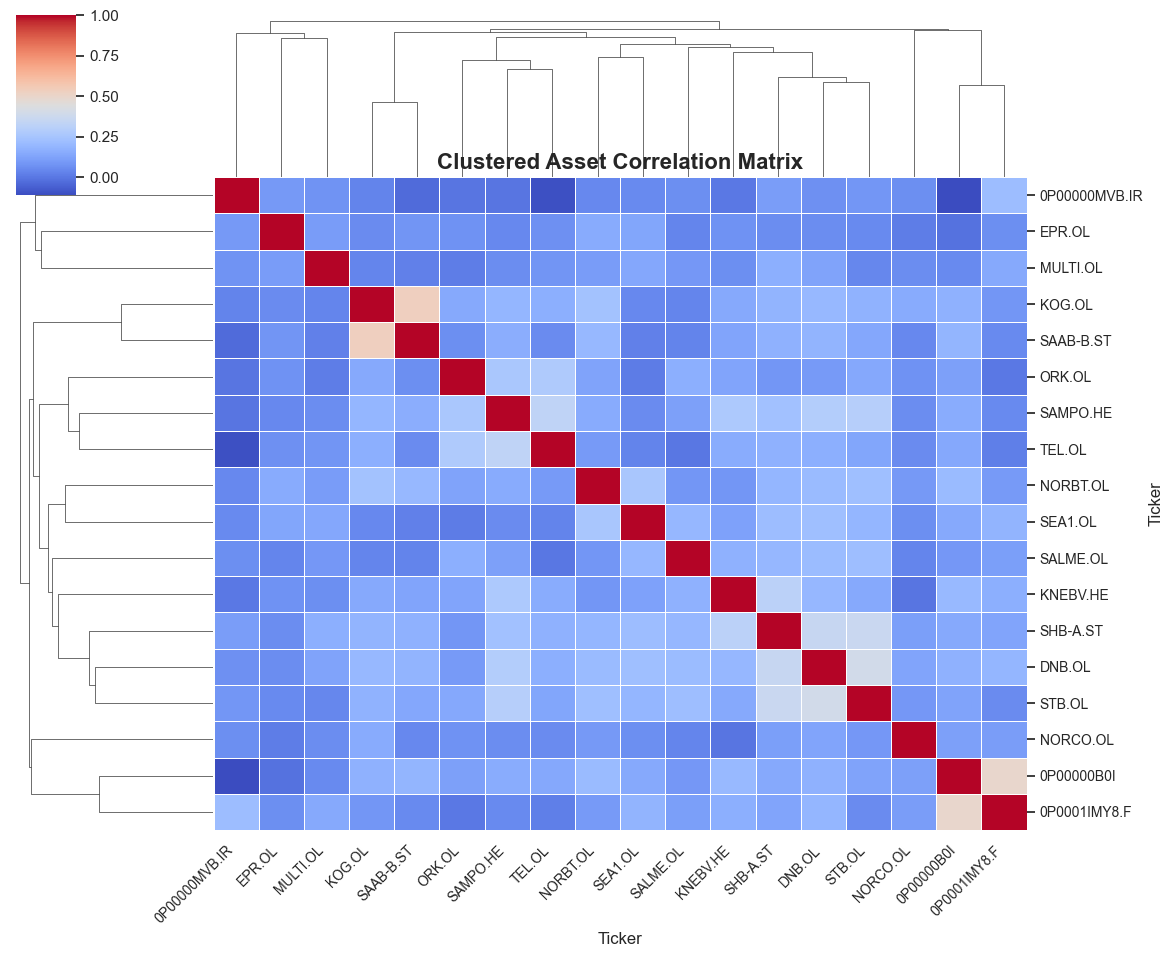


Displaying Correlation Network Graph:


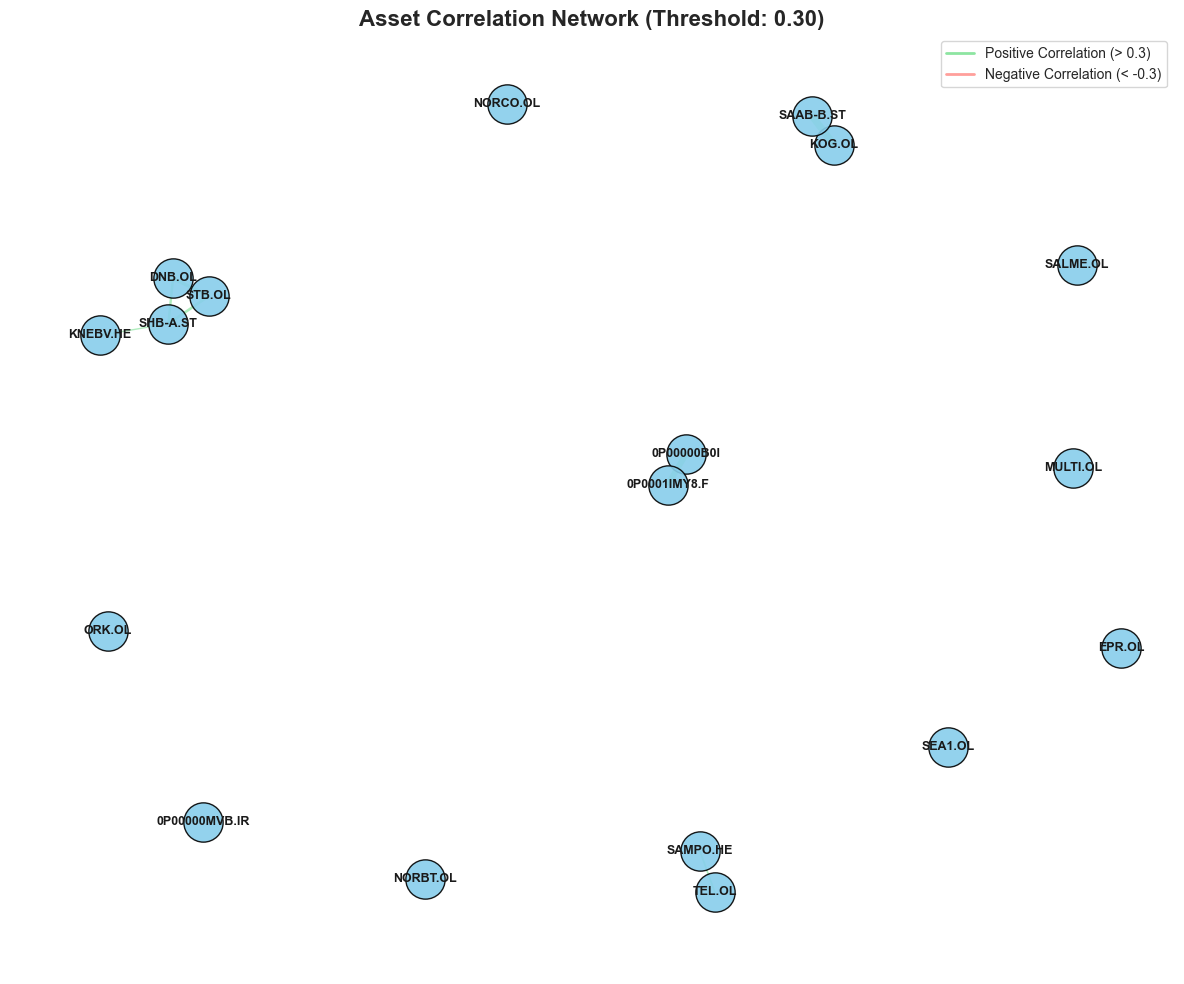

In [5]:
if not cov_matrix.empty:
    correlation_matrix_df = calculate_correlation_matrix(cov_matrix)

    plot_correlation_heatmap(correlation_matrix_df)
    plot_correlation_network(correlation_matrix_df, threshold=0.3)
else:
    print("Covariance matrix is empty. Skipping correlation plots.")

## 3. Interactive Portfolio Optimization
We now find the optimal portfolio weights by maximizing the risk-adjusted return (Sharpe Ratio), subject to constraints like maximum asset allocation. The L2 regularization parameter (`lambda_reg`) can be adjusted interactively to control for overfitting and encourage diversification.

In [6]:
if "model_inputs" in locals() and not model_inputs.mean_returns.empty:
    session = PortfolioAnalysisSession(config, model_inputs)

    print("--- Interactive Portfolio Optimization ---")
    interact(
        session.run_interactive_optimization,
        lambda_reg=FloatSlider(
            min=0.0,
            max=2.0,
            step=0.05,
            value=config.optimization.lambda_reg,
            description="L2 Lambda:",
            continuous_update=False,
            layout={"width": "500px"},
        ),
    )
else:
    print("Model inputs not available. Skipping interactive analysis.")

--- Interactive Portfolio Optimization ---


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='L2 Lambda:', layout=Layout(…

## 4. Monte Carlo Simulation
To understand the potential future performance of the optimized portfolio, we run a Monte Carlo simulation. This projects thousands of possible future paths for the portfolio's value, helping to assess the range of potential outcomes. You can interactively adjust simulation parameters, including using a Student's t-distribution to better model extreme market events (fat tails).

In [7]:
if "session" in locals() and session.mc_simulator:
    print("\n--- Monte Carlo Simulation ---")
    interact(
        session.run_interactive_monte_carlo,
        num_sim_interactive=IntSlider(
            min=1000,
            max=100000,
            step=1000,
            value=config.monte_carlo.num_simulations,
            description="Num Simulations:",
            continuous_update=False,
            layout={"width": "500px"},
        ),
        time_horizon_interactive=FloatSlider(
            min=0.5,
            max=10.0,
            step=0.5,
            value=config.monte_carlo.time_horizon_years,
            description="Time Horizon (Yrs):",
            continuous_update=False,
            layout={"width": "500px"},
        ),
        df_t_interactive=IntSlider(
            min=0,
            max=30,
            step=1,
            value=config.monte_carlo.df_t_distribution,
            description="Student-t df (0-2=Normal):",
            continuous_update=False,
            layout={"width": "500px"},
        ),
    )
else:
    print("Analysis session not initialized. Please run the interactive optimization cell first.")



--- Monte Carlo Simulation ---


interactive(children=(IntSlider(value=100000, continuous_update=False, description='Num Simulations:', layout=…

## 5. Efficient Frontier Analysis

The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility). By plotting this frontier, we can visualize the trade-off between risk and return. We highlight two key portfolios on this frontier:
- **Maximum Sharpe Ratio Portfolio**: The portfolio that provides the best return per unit of risk (the tangency portfolio). This is the same portfolio found in the interactive optimization section.
- **Minimum Volatility Portfolio**: The portfolio with the lowest possible risk.


--- Efficient Frontier Analysis ---

Maximum Sharpe Ratio Portfolio:



Minimum Volatility Portfolio:


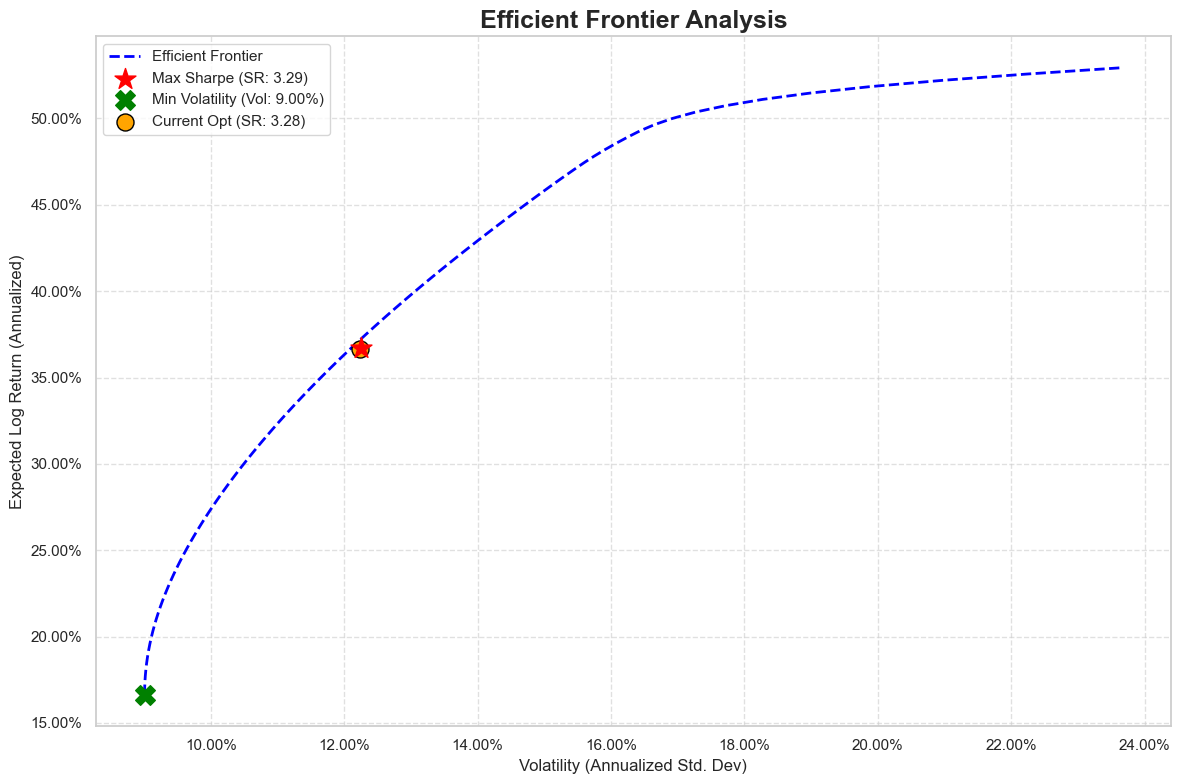

In [8]:
# --- Calculate and Plot the Efficient Frontier ---

print("\n--- Efficient Frontier Analysis ---")

if "session" in locals() and session.optimizer:
    try:
        frontier_df, max_sharpe_res, min_vol_res = session.optimizer.calculate_efficient_frontier()

        print("\nMaximum Sharpe Ratio Portfolio:")
        display(display_optimization_summary_html(max_sharpe_res))

        print("\nMinimum Volatility Portfolio:")
        display(display_optimization_summary_html(min_vol_res))

        # Plot the efficient frontier, highlighting the interactively found portfolio
        plot_efficient_frontier(
            frontier_df,
            max_sharpe_res,
            min_vol_res,
            current_opt_result=session.latest_result,
        )
    except Exception as e:
        print(f"Could not generate efficient frontier: {e}")
else:
    print("Analysis session not initialized. Please run the interactive optimization cell first.")

## 6. Strategy Backtesting

Finally, we perform a historical backtest to evaluate how the strategy would have performed over time. The backtester rebalances the portfolio at a fixed frequency (e.g., every 3 months), using a rolling lookback window to generate new optimization inputs at each step.

In [ ]:
# Define a benchmark index to compare against
# ^OSEBX is the Oslo Børs Benchmark Index

benchmark_ticker = "OSEBX.OL"

# Initialize and run the backtester
backtester = Backtester(config)
backtest_results, performance_metrics = backtester.run(benchmark_ticker=benchmark_ticker)

clear_output(wait=True)

if not backtest_results.empty:
    # Display performance metrics using the new reporting function
    display(display_backtest_summary_html(performance_metrics))

    # Plot the results
    plt.figure(figsize=(14, 7))
    backtest_results["Portfolio Value"].plot(linewidth=2, label="Strategy")

    if "Benchmark Value" in backtest_results.columns:
        backtest_results["Benchmark Value"].plot(
            linewidth=2, label=f"Benchmark ({benchmark_ticker})", linestyle="--"
        )

    plt.title("Backtest: Strategy vs. Benchmark", fontsize=16, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value", fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Backtest did not produce any results.")

2025-06-21 15:48:59 - portfolio_analyzer.analysis.backtester - INFO - --- Running Backtest for 'Mean-Variance Optimization' ---
2025-06-21 15:48:59 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 19 tickers...


C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\analysis\backtester.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = pd.date_range(
Backtesting:   0%|          | 0/20 [00:00<?, ?it/s]

2025-06-21 15:48:59 - portfolio_analyzer.data.input_preparator - INFO - --- Starting Data Pipeline for 18 tickers from 2017-07-01 to 2020-06-30 ---
2025-06-21 15:48:59 - portfolio_analyzer.data.input_preparator - INFO - DCF Views Enabled: True
2025-06-21 15:48:59 - portfolio_analyzer.data.data_fetcher - INFO - Fetching market cap data for 18 tickers...
2025-06-21 15:49:02 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000MVB.IR. Defaulting to 0.
2025-06-21 15:49:03 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P0001IMY8.F. Defaulting to 0.
2025-06-21 15:49:03 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000B0I. Defaulting to 0.
2025-06-21 15:49:03 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 18 tickers...
2025-06-21 15:49:06 - yfinance - ERROR - 
6 Failed downloads:
2025-06-21 15:49:06 - yfinance - ERROR - ['0P00000MVB.IR']: YFPricesMissin

Exception ignored from cffi callback <function buffer_callback at 0x0000022CB5FE3E20>:
Traceback (most recent call last):
  File "c:\Users\Aksel\Desktop\portfolio-analyzer\.venv\Lib\site-packages\curl_cffi\curl.py", line 68, in buffer_callback
    @ffi.def_extern()
KeyboardInterrupt: 


2025-06-21 15:49:09 - portfolio_analyzer.data.dcf_calculator - INFO - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
2025-06-21 15:49:09 - portfolio_analyzer.data.dcf_calculator - INFO - Skipping 0P00000MVB.IR: Missing essential data (beta, mkt_cap, etc.).
2025-06-21 15:49:10 - portfolio_analyzer.data.dcf_calculator - INFO - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
2025-06-21 15:49:10 - portfolio_analyzer.data.dcf_calculator - INFO - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).
2025-06-21 15:49:10 - portfolio_analyzer.data.data_fetcher - INFO - Successfully generated 5 DCF views.
2025-06-21 15:49:10 - portfolio_analyzer.data.input_preparator - INFO - Calculating annualized covariance matrix using Ledoit-Wolf shrinkage...
2025-06-21 15:49:10 - portfolio_analyzer.data.input_preparator - INFO - Constructing Black-Litterman views from DCF estimates...
2025-06-21 15:49:10 - portfolio_analyzer.data.input_preparator - INFO - 

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\analysis\backtester.py:110: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:   5%|▌         | 1/20 [00:10<03:17, 10.39s/it]

2025-06-21 15:49:10 - portfolio_analyzer.data.input_preparator - INFO - --- Starting Data Pipeline for 18 tickers from 2017-10-01 to 2020-09-30 ---
2025-06-21 15:49:10 - portfolio_analyzer.data.input_preparator - INFO - DCF Views Enabled: True
2025-06-21 15:49:10 - portfolio_analyzer.data.data_fetcher - INFO - Fetching market cap data for 18 tickers...
